# Regression: Predicting Age of First Cigarette Use



In [1]:
# Data Loading
import pandas as pd
df = pd.read_csv("../data/processed_data.csv")


## Data Cleaning & Preprocessing
- Use `IRCIGAGE` as the target (age of first cigarette use).
- Remove non-users (`IRCIGAGE` >= 900) and outliers (IQR method).
- Impute missing values for features using the median.


In [2]:
# Filter for valid age of first cigarette use
df_users = df[df['IRCIGAGE'] < 900].copy()

# Remove outliers in target variable (IQR method)
y = df_users['IRCIGAGE']
q1, q3 = y.quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df_users = df_users[(y >= lower_bound) & (y <= upper_bound)].copy()


## Feature Engineering
- Create interpretable features and interactions based on the NSDUH codebook and project PDF:
    - School_Satisfaction = SCHFELT × AVGGRADE
    - Parental_Support = PARHLPHW × PARCHKHW
    - Peer_Influence = FRDPCIG2 × FRDMEVR2
    - Risk_Taking = YOFIGHT2 + YOGRPFT2
    - Income_Access = INCOME × PRPKCIG2
    - Peer_Parent_Interaction = Peer_Influence × Parental_Support
    - School_Risk_Interaction = SCHFELT × Risk_Taking
    - Total_Risk = YOFIGHT2 + YOGRPFT2 + YOSTOLE2
    - Years_Since_First_Drink = IRCIGAGE - IRALCAGE
    - Income_Squared = INCOME²
    - Peer_Influence_Squared = Peer_Influence²


In [3]:
df_users['School_Satisfaction'] = df_users['SCHFELT'] * df_users['AVGGRADE']
df_users['Parental_Support'] = df_users['PARHLPHW'] * df_users['PARCHKHW']
df_users['Peer_Influence'] = df_users['FRDPCIG2'] * df_users['FRDMEVR2']
df_users['Risk_Taking'] = df_users['YOFIGHT2'] + df_users['YOGRPFT2']
df_users['Income_Access'] = df_users['INCOME'] * df_users['PRPKCIG2']
df_users['Peer_Parent_Interaction'] = df_users['Peer_Influence'] * df_users['Parental_Support']
df_users['School_Risk_Interaction'] = df_users['SCHFELT'] * df_users['Risk_Taking']
df_users['Total_Risk'] = df_users['YOFIGHT2'] + df_users['YOGRPFT2'] + df_users['YOSTOLE2']
df_users['Years_Since_First_Drink'] = df_users['IRCIGAGE'] - df_users['IRALCAGE']
df_users['Income_Squared'] = df_users['INCOME'] ** 2
df_users['Peer_Influence_Squared'] = df_users['Peer_Influence'] ** 2

features = [
    'School_Satisfaction', 'Parental_Support', 'Peer_Influence', 'Risk_Taking',
    'Income_Access', 'Peer_Parent_Interaction', 'School_Risk_Interaction',
    'Total_Risk', 'Years_Since_First_Drink', 'INCOME', 'Income_Squared',
    'Peer_Influence_Squared', 'HEALTH2', 'YTHACT2', 'STNDSCIG', 'STNDSMJ', 'STNDALC'
]
X = df_users[features].copy()
y = df_users['IRCIGAGE'].copy()
X = X.fillna(X.median())
y = y.fillna(y.median())


## Data Splitting & Scaling
- Standardize features for fair model comparison.
- Use an 80/20 train-test split.


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


## Modeling

### Decision Tree Regressor
- **Max Depth**: 5
- **Min Samples Leaf**: 10


In [5]:
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, random_state=42)

Decision Tree Info:
Total Nodes in Tree: 33
Total Leaves in Tree: 17
Max Depth of Tree: 5


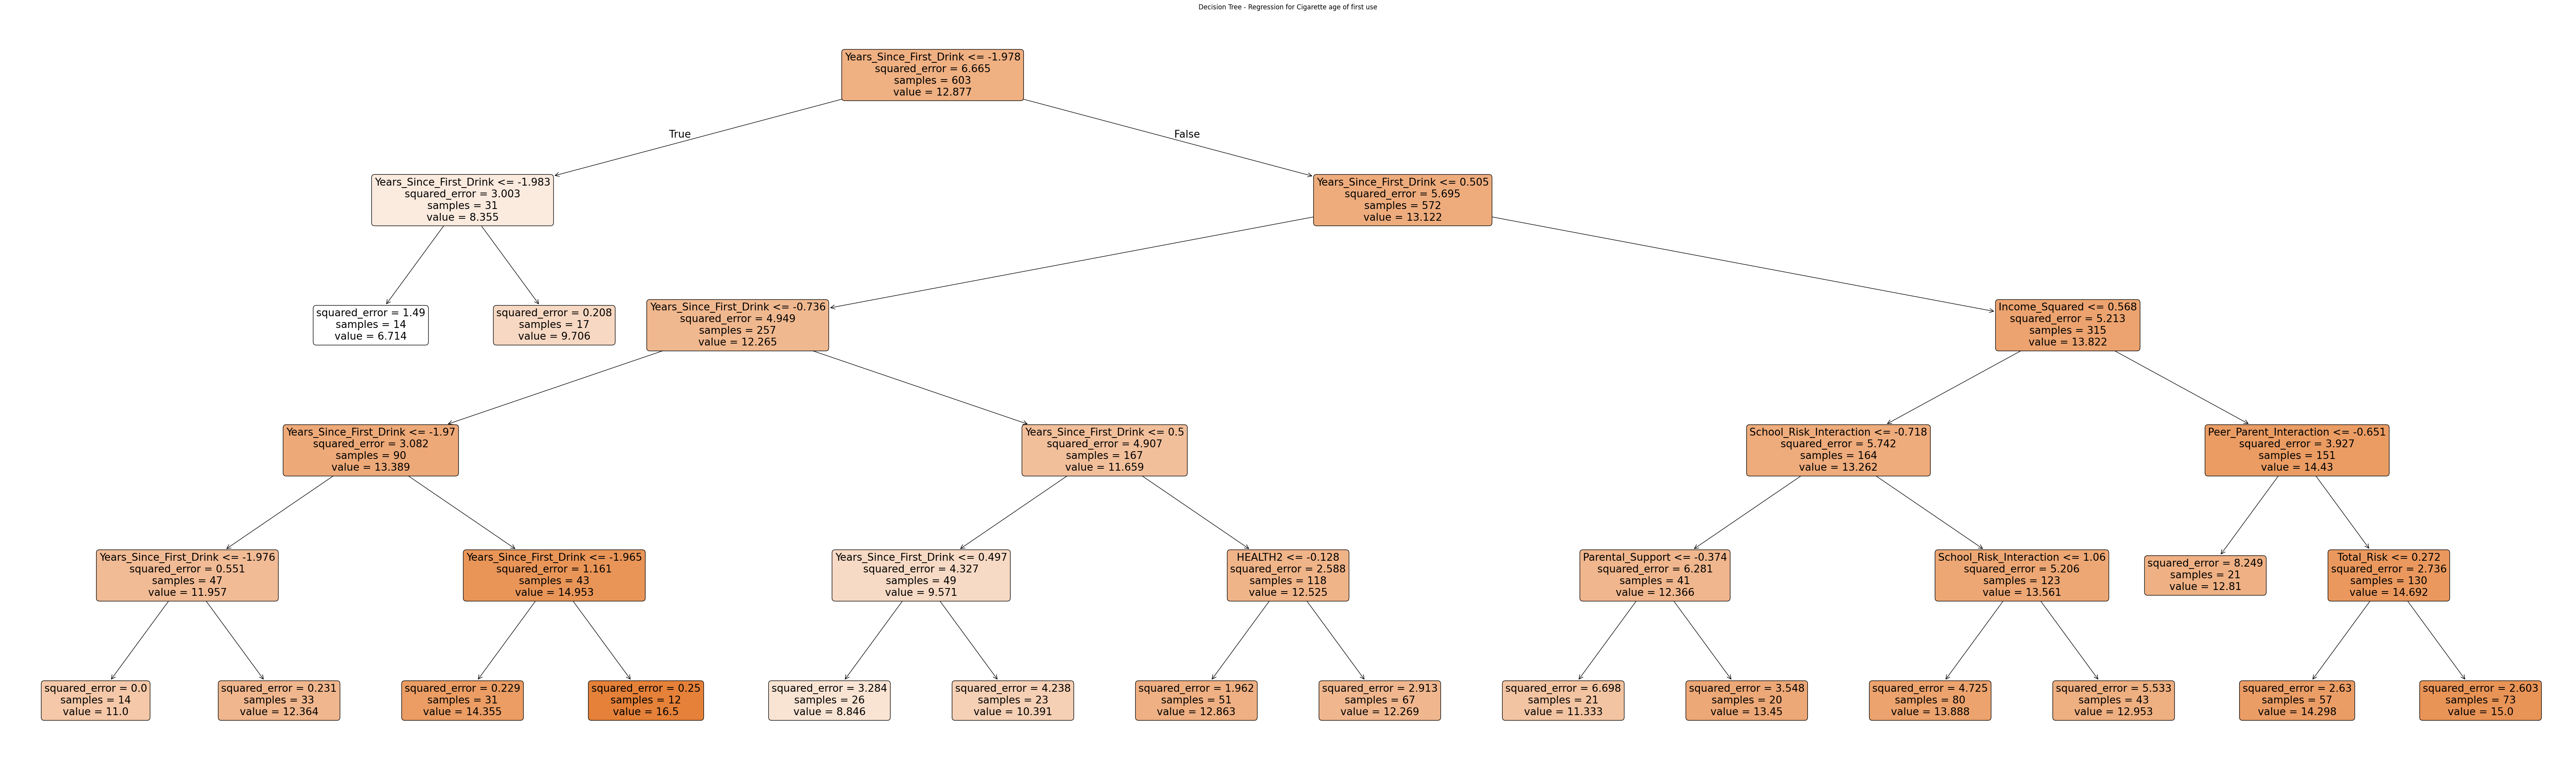

In [6]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
# Print Decision Tree structure info
print("Decision Tree Info:")
print(f"Total Nodes in Tree: {dt_model.tree_.node_count}")
print(f"Total Leaves in Tree: {dt_model.get_n_leaves()}")
print(f"Max Depth of Tree: {dt_model.tree_.max_depth}")
plt.figure(figsize=(85, 25))
plot_tree(dt_model, feature_names=X.columns, filled=True, rounded=True)
plt.title("Decision Tree - Regression for Cigarette age of first use")
plt.savefig("../results/decision_tree_structure.png")
plt.show()
plt.close()


### Bagging Regressor
- **Base Estimator**: Decision Tree
- **n_estimators**: 50


In [7]:
from sklearn.ensemble import BaggingRegressor

bag_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, random_state=42),
    n_estimators=50,
    random_state=42
)
bag_model.fit(X_train, y_train)


BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=5,
                                                 min_samples_leaf=10,
                                                 random_state=42),
                 n_estimators=50, random_state=42)

### Random Forest Regressor
- **n_estimators**: 100
- **Max Depth**: 8


In [8]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=100, max_depth=8, min_samples_leaf=5, random_state=42
)
rf_model.fit(X_train, y_train)


RandomForestRegressor(max_depth=8, min_samples_leaf=5, random_state=42)

### Gradient Boosting Regressor
- **n_estimators**: 200
- **Learning Rate**: 0.05
- **Max Depth**: 5


In [9]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(
    n_estimators=200, learning_rate=0.05, max_depth=5, subsample=0.8, random_state=42
)
gb_model.fit(X_train, y_train)


GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=200,
                          random_state=42, subsample=0.8)

## Model Evaluation & Comparison
- Metrics: RMSE, R²
- Show actual vs predicted plots for each model


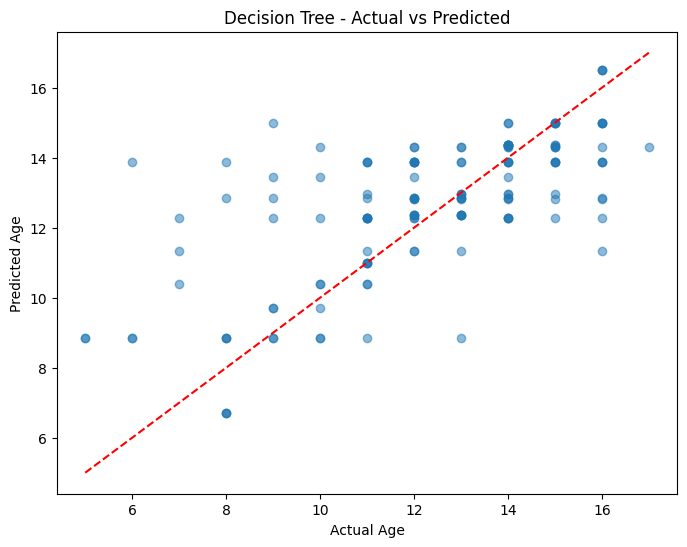

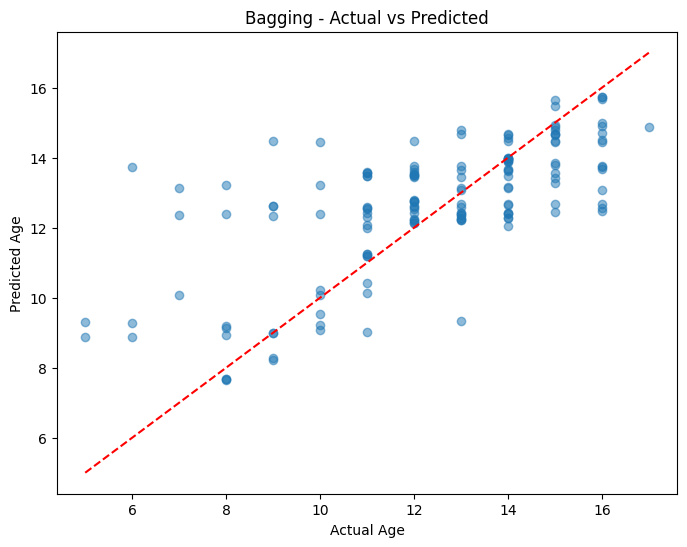

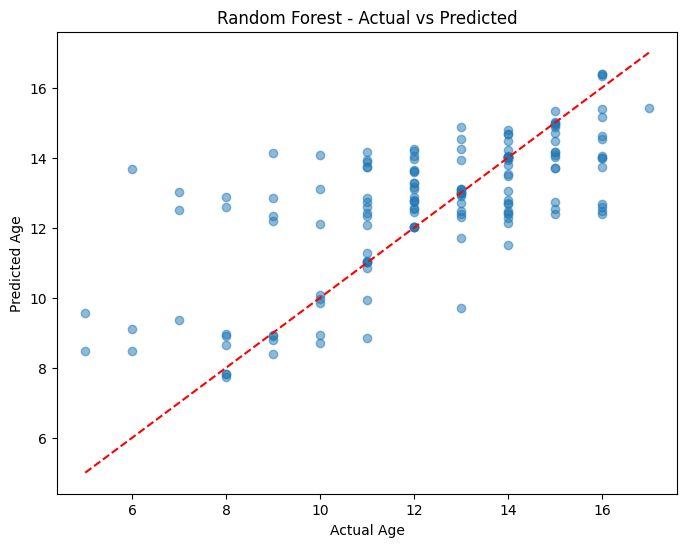

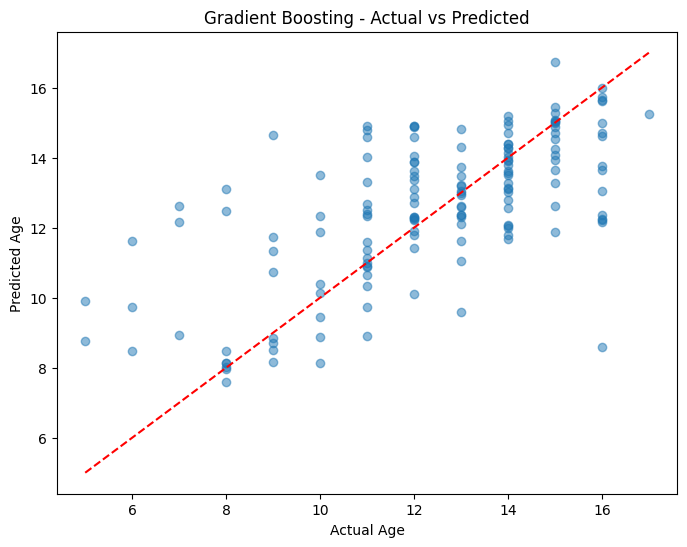


Model Performance Comparison:
               Model      RMSE        R²
0      Decision Tree  1.986366  0.437636
1            Bagging  1.944409  0.461142
2      Random Forest  1.939667  0.463767
3  Gradient Boosting  2.038281  0.407856


In [10]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

models = {
    'Decision Tree': dt_model,
    'Bagging': bag_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results.append({'Model': name, 'RMSE': rmse, 'R²': r2})
    
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel('Actual Age')
    plt.ylabel('Predicted Age')
    plt.title(f'{name} - Actual vs Predicted')
    plt.savefig(f"../results/{name.replace(' ', '_')}_actual_vs_predicted.png")
    plt.show()
    plt.close()

results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df)


## Feature Importance (Best Model Only)
- Plot feature importance for the model with the highest R².


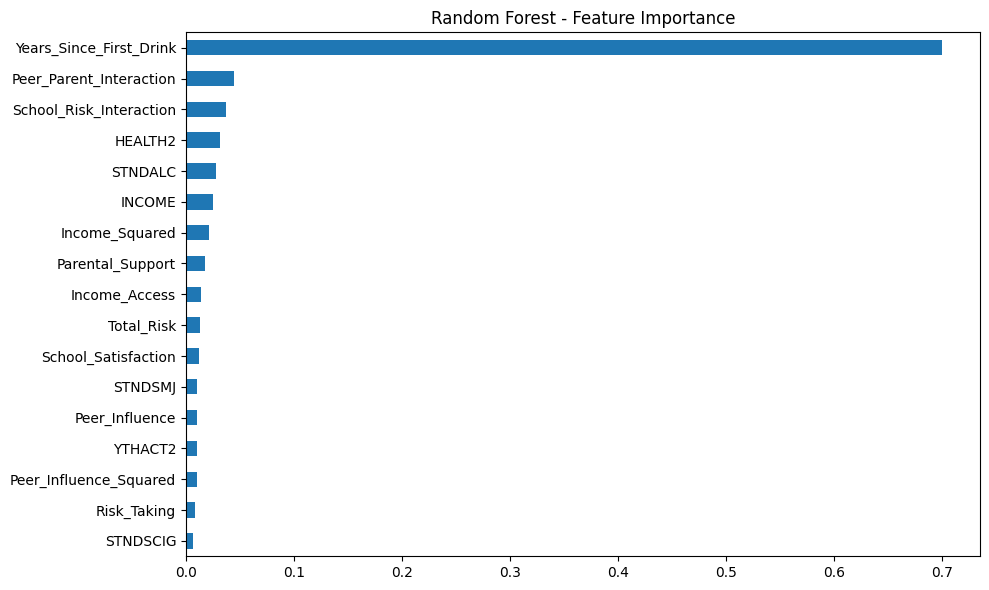

In [11]:
best_model_name = results_df.sort_values('R²', ascending=False).iloc[0]['Model']
best_model = models[best_model_name]
if hasattr(best_model, "feature_importances_"):
    plt.figure(figsize=(10,6))
    pd.Series(best_model.feature_importances_, index=features).sort_values().plot.barh()
    plt.title(f'{best_model_name} - Feature Importance')
    plt.tight_layout()
    plt.savefig(f"../results/{best_model_name.replace(' ', '_')}_feature_importance.png")
    plt.show()
    plt.close()


## Feature Importance Interpretation

The Random Forest model's feature importance plot for predicting the age of first cigarette use reveals the following:

- **Years_Since_First_Drink** is by far the most influential predictor, accounting for over 70% of the model's total importance. This suggests that the time elapsed between first alcohol use and first cigarette use is a dominant factor in determining when youth initiate cigarette use. This finding aligns with the "gateway" hypothesis discussed in the literature and highlighted in our project PDF, indicating that early alcohol initiation is a strong risk marker for earlier cigarette initiation.

- **Peer_Parent_Interaction** and **School_Risk_Interaction** are the next most important features, though their relative contributions are much smaller. This indicates that the combination of peer influence and parental support, as well as the interaction between school safety and risk-taking behaviors, play a secondary but meaningful role in predicting initiation age.

- Other features such as **HEALTH2** (general health), **STNDALC** (alcohol risk perception), **INCOME**, and **Parental_Support** contribute modestly to the model. Classic risk and demographic factors, while relevant, are overshadowed by the temporal relationship with alcohol use.

- Many engineered features (e.g., **Income_Squared**, **Peer_Influence_Squared**, **Total_Risk**) have low or negligible importance, suggesting that the model's predictive power is concentrated in a small number of key variables.

**Key Insight:**  
The overwhelming importance of "Years_Since_First_Drink" highlights the need for early interventions targeting alcohol use among youth. Prevention efforts that delay the onset of alcohol use may have a significant downstream effect on postponing or preventing cigarette initiation.

**Policy Implication:**  
Programs designed to delay first alcohol use, combined with efforts to strengthen parental support and improve school safety, could be most effective in reducing early cigarette initiation among adolescents.

**Limitations:**  
While the model identifies strong predictors, the dominance of a single feature suggests that other unmeasured factors may also play a role, and the results should be interpreted in the context of the available variables and potential survey limitations.
